## Additional checks of normalization to absolute units

A key result of this work is the total moment sum rule, which relies upon a correct normalization to absolute units. In the original work, this was done independently accross all measurements. The methods for each were the following:

1) SEQ data was normalized to a vanadium standard
2) MACS data was normalized to all available nuclear Bragg peaks
3) HYS data was normalized to all available nuclear Bragg peaks

In this notebook, we cross-check this normalization with the assumption that the vanadium standard normalization is correct, as this is independent of any sample properties like structural disorder which may influence the Bragg normalzation. We assume that the integrated Elastic line in each measurement must have the same intensity. Assuming that the SEQ measurement has been normalized properly, we may then recover the normalization factors of the MACS and HYS measurements by scaling the integrated elastic line of each measurement to match.

First, we determine the FWHM of the elastic line for each measurement.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import matplotlib
from mantid.simpleapi import *
import matplotlib.patheffects as PathEffects
import matplotlib.patheffects as PathEffects
cwd=os.getcwd()
sys.path.append("../python scripts/")


from nxspetomd import *
from genslices import *
import MDUtils as mdu
from getcolor import *
from cut_mdhisto_powder import *
from mdfactorization import *
from trapzerr import *
from mask_minQ import *
from maskQEbox import *
#Style sheet updates 
plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.direction']='in'
plt.rcParams['xtick.minor.visible']=True
plt.rcParams['ytick.minor.visible']=True
plt.rcParams['xtick.top']=True
plt.rcParams['ytick.right']=True
plt.rcParams['font.size']=10
plt.rcParams['xtick.labelsize']=10
plt.rcParams['ytick.labelsize']=10
plt.rcParams['text.usetex']=False
plt.rcParams['font.family']='serif'
plt.close('all')
%matplotlib inline

FrameworkManager-[Notice] Welcome to Mantid 6.9.1
FrameworkManager-[Notice] Please cite: http://dx.doi.org/10.1016/j.nima.2014.07.029 and this release: http://dx.doi.org/10.5286/Software/Mantid6.9.1
DownloadInstrument-[Notice] All instrument definitions up to date


In [2]:
# Import all of the relevant files. Only high temp to avoid magnetic signal.

mds = {}
keys= ['seq_200K','macs_5p0_55K','macs_3p7_55K','hys_nsf_tot']
fdict = {keys[0]:'../MDHisto_files/ei30_200K_manualmask.nxspe',\
        keys[1]:'../MDHisto_files/macs_5p0_55K_orig.nxs',\
        keys[2]:'../MDHisto_files/macs_3p7_55K_orig.nxs',\
        keys[3]:'../MDHisto_files/HLIO_tot_NSF.nxspe'}

#Vanadium normalization factors, per Ir
# for Ei=30meV FC2=300Hz
van_factor_30 =  45602.6555# mbarn/meV/sr/ mol (Li2IrO3)

fu_hlio_over_lio = 0.0074 / 0.015 # from 3.6g hlio to 3.8g beta-lio
van30_permolfu_hlio = van_factor_30*fu_hlio_over_lio
van_factor_30 = van30_permolfu_hlio / 2.0 # per Ir 
# For Ei=60meV FC2=420Hz 
van_factor_60 = 32195.135
van_factor_60 = van_factor_60*fu_hlio_over_lio / 2.0 

#SEQ Ei=30 import
qslice_seq = GenQslice(0,3.5,110)
eslice_seq = GenEslice(-10,10,40)
key = keys[0]
seqmd = NxspeToMDHisto(fdict[key],qslice_seq,eslice_seq,numEvNorm=False)
seqmd*=van_factor_30
outws=CloneWorkspace(seqmd,OutputWorkspace=key)
mds[key]=outws

#MACS Ef=5p0 import
key = keys[1]
ws_macs_5p0 = LoadMD(fdict[key])
Ef = 5.0
ws_macs_5p0 = mask_minQ_fixedEf_MD(ws_macs_5p0,twoThetaMin=12.0,Ef=Ef)
outws=CloneWorkspace(ws_macs_5p0,OutputWorkspace=key)
mds[key]=outws

#MACS Ef=3p7 import
key = keys[2]
ws_macs_3p7 = LoadMD(fdict[key])
Ef = 3.7
ws_macs_3p7 = mask_minQ_fixedEf_MD(ws_macs_3p7,twoThetaMin=12.0,Ef=Ef)
outws=CloneWorkspace(ws_macs_3p7,OutputWorkspace=key)
mds[key]=outws

#HYS NSF import
qslice_hys = GenQslice(0,4,120)
eslice_hys = GenEslice(-10,10,40)
key = keys[3]
hysmd = NxspeToMDHisto(fdict[key],qslice_hys,eslice_hys,numEvNorm=False)
outws=CloneWorkspace(hysmd,OutputWorkspace=key)
mds[key]=outws

LoadNXSPE-[Notice] LoadNXSPE started
LoadNXSPE-[Notice] LoadNXSPE successful, Duration 0.11 seconds
ConvertToMD-[Notice] ConvertToMD started
ConvertToMD-[Notice] ConvertToMD successful, Duration 0.06 seconds
BinMD-[Notice] BinMD started
BinMD-[Notice] BinMD successful, Duration 0.00 seconds
CreateSingleValuedWorkspace-[Notice] CreateSingleValuedWorkspace started
CreateSingleValuedWorkspace-[Notice] CreateSingleValuedWorkspace successful, Duration 0.00 seconds
MultiplyMD-[Notice] MultiplyMD started
MultiplyMD-[Notice] MultiplyMD successful, Duration 0.00 seconds
CreateSingleValuedWorkspace-[Notice] CreateSingleValuedWorkspace started
CreateSingleValuedWorkspace-[Notice] CreateSingleValuedWorkspace successful, Duration 0.00 seconds
MultiplyMD-[Notice] MultiplyMD started
MultiplyMD-[Notice] MultiplyMD successful, Duration 0.00 seconds
CloneWorkspace-[Notice] CloneWorkspace started
CloneWorkspace-[Notice] CloneWorkspace successful, Duration 0.00 seconds
LoadMD-[Notice] LoadMD started
LoadM

FigureCanvasAgg is non-interactive, and thus cannot be shown


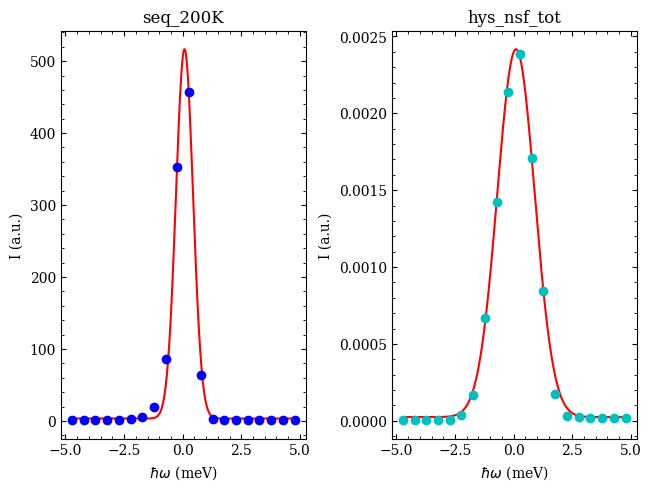

In [3]:
# These have already been absorption corrected. Find FWHM at elastic line for HYS, SEQ.
# This quantity is known experimentally on MACS, but we can determine it here with the 
# finer energy steps of the Tof instruments. 

from lmfit.models import GaussianModel,LinearModel

gaussmodel=GaussianModel(prefix="gauss_")
linmodel=LinearModel(prefix="bkg_")

FWHMs = {}
FWHMs[keys[1]]= 0.35 #Macs Ef=5
FWHMs[keys[2]]= 0.19  #Macs Ef=3.7

fig,ax = plt.subplots(1,2,constrained_layout=True)
clist = ['b','r','darkorange','c']
ax_i = 0
for i,key in enumerate(keys):
    if 'macs' not in key:
        md = mds[key]
        # Take a cut where there are few bragg peaks
        e,Ie,erre = cut_MDHisto_powder(md,'DeltaE',[-5,5,0.05],[1.0,2.2])
        ax[ax_i].errorbar(e,Ie,yerr=erre,ls=' ',marker='o',color=clist[i],capsize=3)
        # Fit to gaussian
        pars = linmodel.make_params()
        pars.add('bkg_slope',value=0,vary=False)
        pars.add('bkg_intercept',value=1,min=0,max=1e8)
        pars += gaussmodel.guess(Ie,x=e)
        mod = gaussmodel+linmodel
        result = mod.fit(Ie,pars,x=e)
        eval_e = np.linspace(np.min(e),np.max(e),1000)
        eval_result = mod.eval(x=eval_e,params=result.params)
        ax[ax_i].plot(eval_e,eval_result,'r-')
        #print(result.fit_report())
        fwhm = result.params['gauss_fwhm'].value
        FWHMs[key]=fwhm
        ax[ax_i].set_xlabel("$\hbar\omega$ (meV)")
        ax[ax_i].set_ylabel("I (a.u.)")
        ax[ax_i].set_title(key)
        ax_i+=1

fig.show()

Integrating over the elastic line is performed for the MACS measurements by multiplying the zero-energy point by the FWHM. The elastic line was not measured in the Ef=3.7 meV configuration, so to scale it to the correct intensity we account for the elastic lineshape at the lowest measured energy transfer of 0.11 meV

For the ToF measurements, we use the IntegrateMDHisto algorithm over the elastic line.

To normalize all the measurements to SEQ, we now minimize the following expression:

$\chi^2 = \sum_q \frac{(I_{SEQ}(q) - {\cal A}I(q))^2}{\delta I_{SEQ}(q)^2 + {\cal A}\delta I(q)^2} $ 

$\frac{d \chi^2}{d{\cal A}} = 0 $

Which is solved exactly by: 

${\cal A} = \sum\frac{I_{SEQ}(q)I(q)}{I(q)^2} / \sum \frac{I_{SEQ}^2}{\delta I(q)^2}$

IntegrateMDHistoWorkspace-[Notice] IntegrateMDHistoWorkspace started
IntegrateMDHistoWorkspace-[Notice] IntegrateMDHistoWorkspace successful, Duration 0.02 seconds
IntegrateMDHistoWorkspace-[Notice] IntegrateMDHistoWorkspace started
IntegrateMDHistoWorkspace-[Notice] IntegrateMDHistoWorkspace successful, Duration 0.03 seconds
HYSPEC NSF Elastic line normalization: 1.274e+05
Cross check Bragg peak normalization: 1.485e+05
MACS Ef=5.0 Elastic line normalization: 1.366e-02
Cross check Bragg peak normalization: 1.481e-02
MACS Ef=3.7 Elastic line normalization: 1.035e-01
Cross check Bragg peak normalization: 1.028e-01
SEQ $E_i$=30 meV, ${\cal N}$=1.125e+04
MACS $E_f$=5 meV, ${\cal N}$=1.366e-02 ${\cal N}_{Bragg}$=1.481e-02
MACS $E_f$=3.7 meV, ${\cal N}$=1.035e-01 ${\cal N}_{Bragg}$=1.028e-01
HYS $\sigma_{NSF}^{x+y+z}$, ${\cal N}$=1.274e+05 ${\cal N}_{Bragg}$=1.485e+05


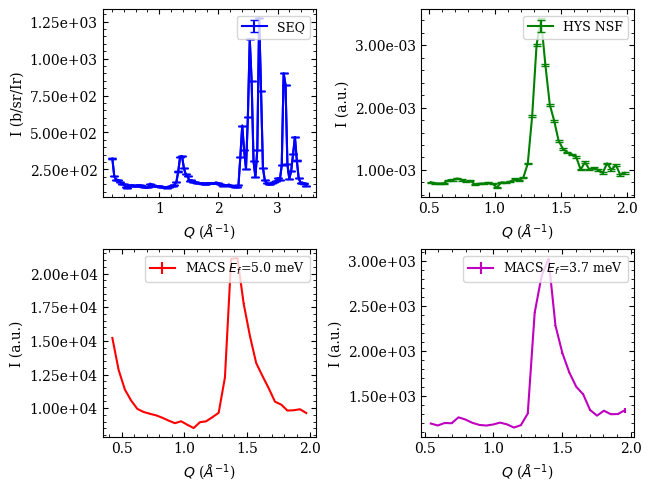

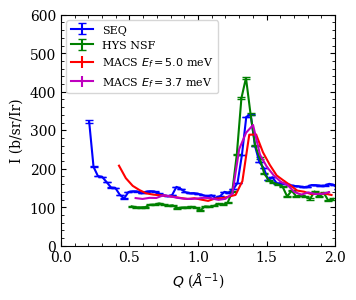

In [12]:
macs3p7md = mds['macs_3p7_55K']
I = np.copy(macs3p7md.getSignalArray())
Err = np.sqrt(np.copy(macs3p7md.getErrorSquaredArray()))
Ielastic_macs3p7 = I[:,0]*FWHMs['macs_3p7_55K'] * 2.1557
Errelastic_macs3p7 = Err[:,0]*FWHMs['macs_3p7_55K'] *2.1557
dims = macs3p7md.getNonIntegratedDimensions()
qmacs3p7 = mdu.dim2array(dims[0])
#Mask low angle scattering. 
Ielastic_macs3p7[qmacs3p7<0.5]=np.nan

macs5p0md = mds['macs_5p0_55K']
I = np.copy(macs5p0md.getSignalArray())
Err = np.sqrt(np.copy(macs5p0md.getErrorSquaredArray()))
Ielastic_macs5p0 = I[:,0]*FWHMs['macs_5p0_55K']
Errelastic_macs5p0 = Err[:,0]*FWHMs['macs_5p0_55K']
dims = macs5p0md.getNonIntegratedDimensions()
qmacs5p0 = mdu.dim2array(dims[0])
#Mask low angle scattering. 
Ielastic_macs5p0[np.logical_or(qmacs5p0<0.4,qmacs5p0>2.0)]=np.nan

mdseq = mds['seq_200K']
int_SEQ_md=IntegrateMDHistoWorkspace(mdseq,P1Bin=[],P2bin=[-1.5,1.5])
seq_events = np.copy(int_SEQ_md.getNumEventsArray()).flatten()
Iseq = np.copy(int_SEQ_md.getSignalArray()).flatten()/seq_events
Errseq = np.sqrt(np.copy(int_SEQ_md.getErrorSquaredArray())).flatten()/seq_events
dimseq = int_SEQ_md.getNonIntegratedDimensions()
qseq = mdu.dim2array(dimseq[0])

mdhys = mds['hys_nsf_tot']
int_HYS_md=IntegrateMDHistoWorkspace(mdhys,P1Bin=[],P2bin=[-2,2])
hys_events = np.copy(int_HYS_md.getNumEventsArray()).flatten()
Ihys = np.copy(int_HYS_md.getSignalArray()).flatten()/hys_events
Errhys = np.sqrt(np.copy(int_HYS_md.getErrorSquaredArray())).flatten()/hys_events
dimshys = int_HYS_md.getNonIntegratedDimensions()
qhys = mdu.dim2array(dimshys[0])
#Mask high angle scattering with aluminum. 
Ihys[np.logical_or(qhys<0.5,qhys>2.0)]=np.nan

#Plot of all four elastic lines
fig,ax = plt.subplots(2,2,subplot_kw={'projection':'mantid'},constrained_layout=True)
ax[0,0].errorbar(int_SEQ_md,marker=' ',color='b',ls='-',capsize=3)

ax[0,0].errorbar(qseq,Iseq,Errseq,marker=' ',color='b',ls='-',capsize=3,label='SEQ')
ax[0,1].errorbar(qhys,Ihys,Errhys,marker=' ',color='g',ls='-',capsize=3,label='HYS NSF')
ax[1,0].errorbar(qmacs5p0,Ielastic_macs5p0,yerr=Errelastic_macs5p0,color='r',marker=' ',ls='-',\
                label=r"MACS $E_f$=5.0 meV")
ax[1,1].errorbar(qmacs3p7,Ielastic_macs3p7,yerr=Errelastic_macs3p7,color='m',marker=' ',ls='-',\
                label=r"MACS $E_f$=3.7 meV")
for ind in [[0,0],[0,1],[1,0],[1,1]]:
    ax[ind[0],ind[1]].legend(fontsize=9,loc=1)
    ax[ind[0],ind[1]].set_xlabel(r"$Q$ ($\AA^{-1}$)")
    ax[ind[0],ind[1]].yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter("%.2e"))
    ax[ind[0],ind[1]].set_ylabel("I (a.u.)")
    if ind==[0,0]:
        ax[ind[0],ind[1]].set_ylabel("I (b/sr/Ir)")


#Get the factors:
match_i_hys = []
for i in range(len(qhys)):
    matchi = np.argmin(np.abs(qseq-qhys[i]))
    match_i_hys.append(matchi)
matchseq_hys = Iseq[match_i_hys]
normfact_hys = 1.0*np.nansum(matchseq_hys *Ihys) / np.nansum(Ihys**2)
normfact_hys_bragg = 148530.0 # See other notebook.
print(f"HYSPEC NSF Elastic line normalization: {normfact_hys:.3e}")
print(f"Cross check Bragg peak normalization: {normfact_hys_bragg:.3e}")

match_i_macs5p0 = []
for i in range(len(qmacs5p0)):
    matchi = np.argmin(np.abs(qseq-qmacs5p0[i]))
    match_i_macs5p0.append(matchi)
matchseq_macs5p0 = Iseq[match_i_macs5p0]
normfact_macs5p0 = 1.0*np.nansum(matchseq_macs5p0 *Ielastic_macs5p0) / np.nansum(Ielastic_macs5p0**2)
normfact_macs_bragg_5p0=1.481e-02 #See other notebook
normfact_macs_bragg_3p7=1.028e-01
print(f"MACS Ef=5.0 Elastic line normalization: {normfact_macs5p0:.3e}")
print(f"Cross check Bragg peak normalization: {normfact_macs_bragg_5p0:.3e}")

match_i_macs3p7 = []
for i in range(len(qmacs3p7)):
    matchi = np.argmin(np.abs(qseq-qmacs3p7[i]))
    match_i_macs3p7.append(matchi)
matchseq_macs3p7 = Iseq[match_i_macs3p7]
normfact_macs3p7 = 1.0*np.nansum(matchseq_macs3p7 *Ielastic_macs3p7) / np.nansum(Ielastic_macs3p7**2)

print(f"MACS Ef=3.7 Elastic line normalization: {normfact_macs3p7:.3e}")
print(f"Cross check Bragg peak normalization: {normfact_macs_bragg_3p7:.3e}")

#Overplot all of them with the scale factors.

fig,ax = plt.subplots(1,1,constrained_layout=False,figsize=(3.54,3))
ax.errorbar(qseq,Iseq,Errseq,marker=' ',color='b',ls='-',capsize=3,label='SEQ')
ax.errorbar(qhys,Ihys*normfact_hys,Errhys*normfact_hys,marker=' ',color='g',
            ls='-',capsize=3,label='HYS NSF')
ax.errorbar(qmacs5p0,Ielastic_macs5p0*normfact_macs5p0,
            yerr=Errelastic_macs5p0*normfact_macs_bragg_5p0,color='r',marker=' ',ls='-',
           label=r"MACS $E_f=5.0$ meV")
ax.errorbar(qmacs3p7,Ielastic_macs3p7*normfact_macs3p7,
            yerr=Errelastic_macs3p7*normfact_macs3p7,color='m',marker=' ',ls='-',
           label=r"MACS $E_f=3.7$ meV")
ax.set_xlabel(r"$Q$ ($\AA^{-1}$)")
ax.set_ylabel("I (b/sr/Ir)")
ax.legend(fontsize=8,ncols=1)
infostr_seq = r"SEQ $E_i$=30 meV, ${\cal N}$="+f"{van_factor_30:.3e}"
infostr_macs5p0 = r"MACS $E_f$=5 meV, ${\cal N}$="+f"{normfact_macs5p0:.3e}"+\
    " ${\cal N}_{Bragg}$="+f"{normfact_macs_bragg_5p0:.3e}"
infostr_macs3p7 = r"MACS $E_f$=3.7 meV, ${\cal N}$="+f"{normfact_macs3p7:.3e}"+\
    " ${\cal N}_{Bragg}$="+f"{normfact_macs_bragg_3p7:.3e}"
infostr_hys = r"HYS $\sigma_{NSF}^{x+y+z}$, ${\cal N}$="+f"{normfact_hys:.3e}"+\
    " ${\cal N}_{Bragg}$="+f"{normfact_hys_bragg:.3e}"
infostr = infostr_seq+'\n'+infostr_macs5p0+"\n"+infostr_macs3p7+"\n"+infostr_hys
#ax.text(0.05,0.9,infostr,fontsize=9,horizontalalignment='left',verticalalignment='top',
#        transform=ax.transAxes)
print(infostr)
ax.set_xlim(0,2)
ax.set_ylim(0,600)
fig.savefig("DLIO_alternate_norm.pdf",bbox_inches='tight')